In [1]:
# https://saturncloud.io/blog/how-to-use-vscode-ssh-remote-to-run-jupyter-notebooks/

# Plot the example annotation(s)


## Notes on the format

see `annotation-outline.txt` and `out.json`

- some annotations have multiple results
- all masks 4 color channels are identical (re-evaluate on final data)



In [3]:
import matplotlib.pyplot as plt
import numpy as np
import skimage
import json

In [4]:
image = plt.imread("data/PC-10x-wide.jpg")

data_json = json.load(open('data/annotations.json'))

In [5]:
from lib.label_studio_converter__brush import *

def preprocess(data_json, resize=None):
  """Flat all annotation.results and link to original full datum."""
  data = [struct(
    id = (datum['id'], annotation['id'], result['id']),                                       # combined identifier
    file = datum['file_upload'],                                                              # original name of the coresponding file
    mask = decode_rle(rle=result['value']['rle'], print_params=False)                             # decode RLE mask with original code
         .reshape(size:=(result['original_height'], result['original_width'], 4))                # reshape to original size
      #original = datum,                                                                         # the orignal datum containing more meta data
  ) for datum in data_json for annotation in datum['annotations'] for result in annotation['result']]  # get all nested masks

  assert all(((m:=datum.mask)[:,:,0] == m[:,:,1]).all() and (m[:,:,1] == m[:,:,2]).all() and (m[:,:,2] == m[:,:,3]).all() 
    for datum in data), "This code assumes that all 4 channels of the mask are the same."
  for datum in data: datum.mask = datum.mask[:,:,0]                                   # all channels are the same so just take one

  if resize:
    for datum in data: datum.mask = skimage.transform.resize(datum.mask, resize[:2])    # and scale to match the image resolution (but keep channels at four)
    
  return data

data = preprocess(data_json, resize=image.shape)

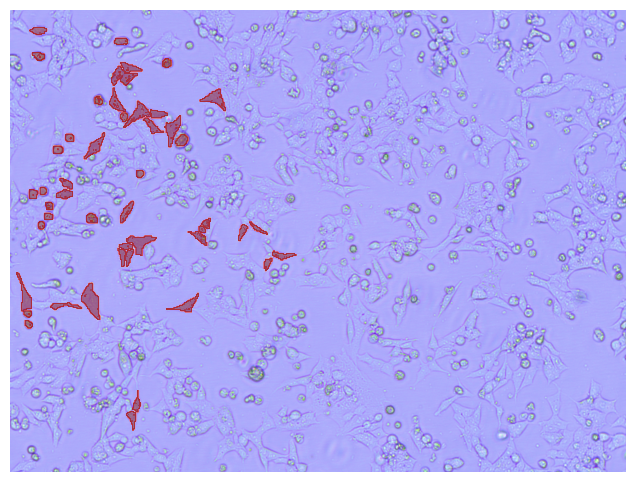

In [6]:

def plot_mask(ax, mask, color):
  def mk_cmap():
    import matplotlib
    cmap = plt.cm.__dict__[color.capitalize()+'s']
    cmap = cmap(np.arange(N:=cmap.N))
    cmap[:,-1] = np.linspace(0, 0.5, N)
    return matplotlib.colors.ListedColormap(cmap)

  ax.contourf(mask, cmap=mk_cmap())
   

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4000//500,3000//500))
ax.axis('off')

ax.imshow(image)
mask = skimage.transform.resize(data[0].mask, image.shape[:2])
plot_mask(ax, mask, 'red')